In [1]:
import deepxde as dde
import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda")

Using backend: pytorch



In [3]:
def pde(x, u):
    u_vel, v_vel, p = u[:, 0:1], u[:, 1:2], u[:, 2:]
    
    Re = x[:, 2:]

    u_vel_x = dde.grad.jacobian(u, x, i=0, j=0)
    u_vel_y = dde.grad.jacobian(u, x, i=0, j=1)
    u_vel_xx = dde.grad.hessian(u, x, component=0, i=0, j=0)
    u_vel_yy = dde.grad.hessian(u, x, component=0, i=1, j=1)

    v_vel_x = dde.grad.jacobian(u, x, i=1, j=0)
    v_vel_y = dde.grad.jacobian(u, x, i=1, j=1)
    v_vel_xx = dde.grad.hessian(u, x, component=1, i=0, j=0)
    v_vel_yy = dde.grad.hessian(u, x, component=1, i=1, j=1)

    p_x = dde.grad.jacobian(u, x, i=2, j=0)
    p_y = dde.grad.jacobian(u, x, i=2, j=1)

    momentum_x = (
        u_vel * u_vel_x + v_vel * u_vel_y + p_x - 1 / Re * (u_vel_xx + u_vel_yy)
    )
    momentum_y = (
        u_vel * v_vel_x + v_vel * v_vel_y + p_y - 1 / Re * (v_vel_xx + v_vel_yy)
    )
    continuity = u_vel_x + v_vel_y

    return [momentum_x, momentum_y, continuity]

In [4]:
def u_func(x):
    Re = x[:, 2:]
    nu = 1 / Re
    l = 1 / (2 * nu) - np.sqrt(1 / (4 * nu ** 2) + 4 * np.pi ** 2)  

    return 1 - torch.exp(l * x[:, 0:1]) * torch.cos(2 * torch.pi * x[:, 1:2])

def v_func(x):
    Re = x[:, 2:]
    nu = 1 / Re
    l = 1 / (2 * nu) - np.sqrt(1 / (4 * nu ** 2) + 4 * np.pi ** 2) 

    return l / (2 * torch.pi) * torch.exp(l * x[:, 0:1]) * torch.sin(2 * torch.pi * x[:, 1:2])

def p_func(x):
    Re = x[:, 2:]
    nu = 1 / Re
    l = 1 / (2 * nu) - np.sqrt(1 / (4 * nu ** 2) + 4 * np.pi ** 2) 

    return 1 / 2 * (1 - torch.exp(2 * l * x[:, 0:1]))

In [26]:
spatial_domain = dde.geometry.Rectangle(xmin=[-0.5, -0.5], xmax=[1, 1.5])

In [27]:
X = spatial_domain.random_points(10000)

In [28]:
X_t = torch.from_numpy(X).to(device)
X_t.requires_grad_()

tensor([[-1.5587e-01,  1.4688e+00],
        [ 9.6519e-01,  7.9063e-01],
        [-4.4124e-01, -1.2608e-03],
        ...,
        [-4.9880e-02,  1.3851e+00],
        [ 1.3280e-01,  1.4890e+00],
        [ 2.4995e-01, -3.1276e-01]], requires_grad=True)

In [29]:
u_exact = u_func(X_t)
v_exact = v_func(X_t)
p_exact = p_func(X_t)

sol_exact = torch.hstack([u_exact, v_exact, p_exact])

In [30]:
resid = pde(X_t, sol_exact)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

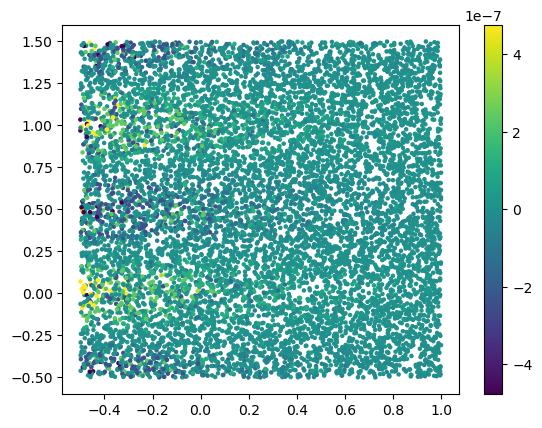

In [12]:
plt.scatter(X[:, 0], X[:, 1], c=resid[2].detach().cpu(), s=5)
plt.colorbar()
plt.show()